In [6]:
# Load libraries
from pyspark.context import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline

In [7]:
# Load minute weather data
spark = SparkSession.builder.master("local").appName("Word Count").getOrCreate()

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

inputfile = "/srv/jupyterhub/read-only/data/minute_weather.csv"
df = spark.read.load (inputfile, format="csv", inferSchema="true", header="true")

In [8]:
# Examine schema

df.printSchema()

root
 |-- rowID: integer (nullable = true)
 |-- hpwren_timestamp: timestamp (nullable = true)
 |-- air_pressure: double (nullable = true)
 |-- air_temp: double (nullable = true)
 |-- avg_wind_direction: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- max_wind_direction: double (nullable = true)
 |-- max_wind_speed: double (nullable = true)
 |-- min_wind_direction: double (nullable = true)
 |-- min_wind_speed: double (nullable = true)
 |-- rain_accumulation: double (nullable = true)
 |-- rain_duration: double (nullable = true)
 |-- relative_humidity: double (nullable = true)



In [9]:
# Count rows

df.count()

1587257

In [10]:
# Filter rows 

filteredDF = df.filter((df.rowID % 100) == 0)
filteredDF.count()

15873

In [11]:
# Show summary statistics

filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,15873,793600.0,458228.4746717515,0,1587200
air_pressure,15873,916.8291627291593,3.0517222151797627,905.1,929.4
air_temp,15873,61.85468909468877,11.835413790821452,32.36,96.44
avg_wind_direction,15870,161.2875236294896,95.31316129656483,0.0,359.0
avg_wind_speed,15870,2.792804032766223,2.07050619846002,0.1,20.1
max_wind_direction,15870,162.70094517958412,92.26960112663168,0.0,359.0
max_wind_speed,15870,3.4146250787649493,2.4289064068121387,0.1,20.9
min_wind_direction,15870,166.64429741650915,97.82483630682518,0.0,359.0
min_wind_speed,15870,2.1522684310018896,1.7581135042599598,0.0,19.5


In [12]:
# Drop null data

workingDF = filteredDF.na.drop()
workingDF.count()

15869

In [13]:
# Create feature vector

featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [14]:
# Scale data

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [15]:
# Use one-third data for elbow plot

scaledData = scaledData.select("features", "rowID")

elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()
elbowset.count()

5289

In [16]:
# Generate clusters for elbow plot

clusters = range(5,20)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 5 
......................WSSE = 8804.694339031907 
Training for cluster size 6 
......................WSSE = 8525.480223872479 
Training for cluster size 7 
......................WSSE = 8250.724863437203 
Training for cluster size 8 
......................WSSE = 7848.19734934203 
Training for cluster size 9 
......................WSSE = 7570.8780978830055 
Training for cluster size 10 
......................WSSE = 7329.067961103764 
Training for cluster size 11 
......................WSSE = 7177.965311120956 
Training for cluster size 12 
......................WSSE = 7065.723853555635 
Training for cluster size 13 
......................WSSE = 7082.4094400840595 
Training for cluster size 14 
......................WSSE = 6802.849359722116 
Training for cluster size 15 
......................WSSE = 6679.158807094141 
Training for cluster size 16 
......................WSSE = 6748.620942357968 
Training for cluster size 17 
......................WSSE = 6528.0721

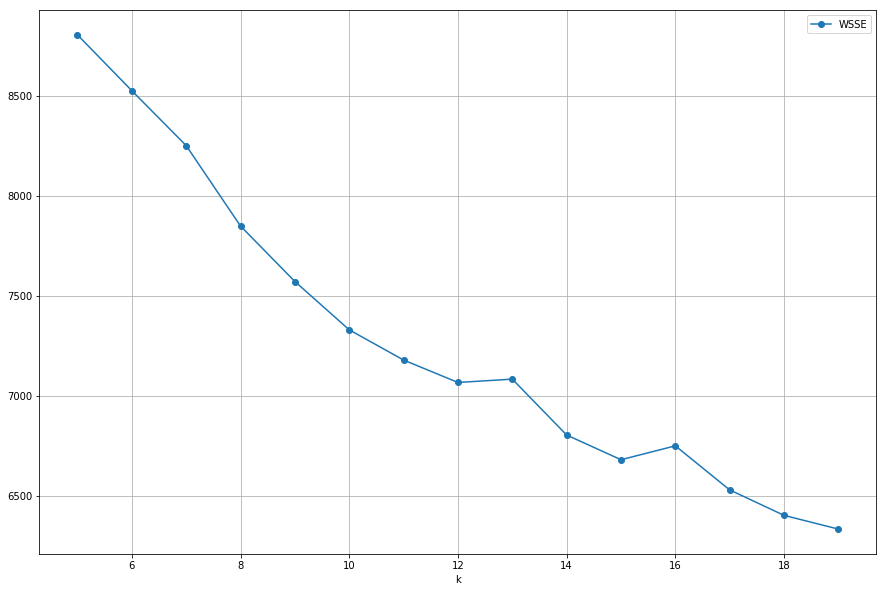

In [17]:
# Show elbow plot

utils.elbow_plot(wsseList, clusters)

In [ ]:
# Run KMeans for k = 12

scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [ ]:
# Compute cluster centers

centers = model.clusterCenters()
P = utils.pd_centers(featuresUsed, centers)
centers

## Dry Days

In [ ]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

## Humid Days

In [ ]:
utils.parallel_plot(P[P['relative_humidity'] > 0.5], P)

## Hot Days

In [ ]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

## Cool Days

In [ ]:
utils.parallel_plot(P[P['air_temp'] < -0.5], P)